# 1. Preprocessing

The current projects have conducted proper investigation for preprocessing and this notebook aims to produce a new dataset that has the unnecessary variables and missing variables filled.

## 1.1 Import necessary libraries

In [1]:
!pip install kmodes


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes

## 1.2 Correlation Analysis

The current projects have conducted detailed correlation analysis on all columns and we will select the columns that they have filtered out.

In [3]:
# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
        dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [4]:
%%time
# LOAD TRAIN
X_train = pd.read_csv('/Users/remuslum/Downloads/ieee-fraud-detection/train_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv('/Users/remuslum/Downloads/ieee-fraud-detection/train_identity.csv',index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv('/Users/remuslum/Downloads/ieee-fraud-detection/test_transaction.csv',index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('/Users/remuslum/Downloads/ieee-fraud-detection/test_identity.csv',index_col='TransactionID', dtype=dtypes)
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 213) test shape (506691, 213)
CPU times: user 21.2 s, sys: 2.96 s, total: 24.1 s
Wall time: 24.8 s


## 1.3 Missing values

### 1.3.1 Distribution of Columns with missing values

We will now deal with the missing values by viewing the distribution of those columns.

In [5]:
def top_missing_cols(df,thresh,n=10):
    """
    returns missing columns in dataframe with missing values percent > thresh
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """
    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    return dff[dff["missing_percent"] > thresh]

In [8]:
df_missing_values_train = top_missing_cols(X_train,70)
df_missing_values_test = top_missing_cols(X_test,70)

There are 195 columns in this dataset with missing values.
There are 101 columns with missing percent values than 70%
There are 196 columns in this dataset with missing values.
There are 101 columns with missing percent values than 70%


In [10]:
cols_to_drop = df_missing_values_train['col'].unique()

The train and test sets both have the same columns with more than **70%** of its values missing. We will drop the same columns from both the train and test sets. 

In [11]:
X_train.drop(columns = cols_to_drop, inplace = True)
X_test.drop(columns = cols_to_drop, inplace = True)

In [12]:
print(X_train.shape)
print(X_test.shape)

(590540, 112)
(506691, 112)


In [13]:
cols_with_missing_train = X_train.columns[X_train.isna().any()].tolist()
cols_with_missing_test = X_test.columns[X_test.isna().any()].tolist()
print("Number of missing columns in train dataset: ", len(cols_with_missing_train))
print("Number of missing columns in test dataset: ", len(cols_with_missing_test))

Number of missing columns in train dataset:  94
Number of missing columns in test dataset:  95


In [17]:
for col in cols_with_missing_train:
    print(col, ":",(X_train[col].isna().mean() * 100).round(2))

card2 : 1.51
card3 : 0.27
card4 : 0.27
card5 : 0.72
card6 : 0.27
addr1 : 11.13
addr2 : 11.13
dist1 : 59.65
P_emaildomain : 15.99
D1 : 0.21
D2 : 47.55
D3 : 44.51
D4 : 28.6
D5 : 52.47
D10 : 12.87
D11 : 47.29
D15 : 15.09
M1 : 45.91
M2 : 45.91
M3 : 45.91
M4 : 47.66
M5 : 59.35
M6 : 28.68
M7 : 58.64
M8 : 58.63
M9 : 58.63
V1 : 47.29
V3 : 47.29
V4 : 47.29
V6 : 47.29
V8 : 47.29
V11 : 47.29
V13 : 12.88
V14 : 12.88
V17 : 12.88
V20 : 12.88
V23 : 12.88
V26 : 12.88
V27 : 12.88
V30 : 12.88
V36 : 28.61
V37 : 28.61
V40 : 28.61
V41 : 28.61
V44 : 28.61
V47 : 28.61
V48 : 28.61
V54 : 13.06
V56 : 13.06
V59 : 13.06
V62 : 13.06
V65 : 13.06
V67 : 13.06
V68 : 13.06
V70 : 13.06
V76 : 15.1
V78 : 15.1
V80 : 15.1
V82 : 15.1
V86 : 15.1
V88 : 15.1
V89 : 15.1
V91 : 15.1
V107 : 0.05
V108 : 0.05
V111 : 0.05
V115 : 0.05
V117 : 0.05
V120 : 0.05
V121 : 0.05
V123 : 0.05
V124 : 0.05
V127 : 0.05
V129 : 0.05
V130 : 0.05
V136 : 0.05
V281 : 0.21
V283 : 0.21
V284 : 0.0
V285 : 0.0
V286 : 0.0
V289 : 0.21
V291 : 0.0
V294 : 0.0
V296 

In [63]:
for col in cols_with_missing_test:
    print(col, ":",(X_test[col].isna().mean() * 100).round(2))

C1 : 0.0
C2 : 0.0
C3 : 0.0
C4 : 0.0
C5 : 0.0
C6 : 0.0
C7 : 0.0
C8 : 0.0
C9 : 0.0
C10 : 0.0
C11 : 0.0
C12 : 0.0
C13 : 0.62
C14 : 0.0


### 1.3.2 Removal of rows 

We first filter out rows with **less than 2%** of missing values in each column. Then, we remove those rows with missing values in those columns.

In [19]:
small_cols = []
for col in cols_with_missing_train:
    if (X_train[col].isna().mean() * 100).round(2) < 2 :
        small_cols.append(col)

In [20]:
small_cols

['card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'D1',
 'V107',
 'V108',
 'V111',
 'V115',
 'V117',
 'V120',
 'V121',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V281',
 'V283',
 'V284',
 'V285',
 'V286',
 'V289',
 'V291',
 'V294',
 'V296',
 'V297',
 'V301',
 'V303',
 'V305',
 'V307',
 'V309',
 'V310',
 'V314',
 'V320']

In [21]:
X_train = X_train.dropna(subset = small_cols)
X_test = X_test.dropna(subset = small_cols)

In [22]:
print("Number of columns in train dataset:",X_train.shape)
print("Number of columns in test dataset:",X_test.shape)

Number of columns in train dataset: (578081, 112)
Number of columns in test dataset: (491009, 112)


### 1.3.3 Investigation of Distribution (D columns)

In [25]:
remaining_cols = [item for item in cols_with_missing_train if item not in small_cols]
D_columns = []
for col in remaining_cols:
    if 'D' in col:
        D_columns.append(col)
D_columns

['D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15']

Distribution of D Columns

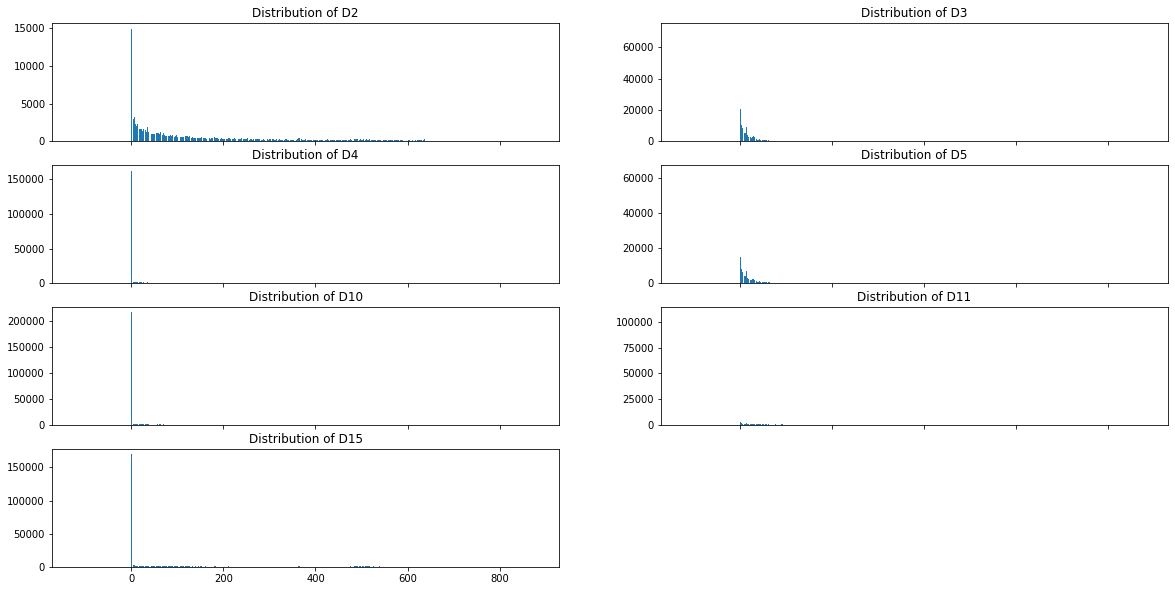

In [29]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (20,10), sharex = True)

value_counts_D2 = X_train['D2'].value_counts()
axes[0,0].bar(value_counts_D2.index, value_counts_D2.values)
axes[0,0].set_title("Distribution of D2")

value_counts_D3 = X_train['D3'].value_counts()
axes[0,1].bar(value_counts_D3.index, value_counts_D3.values)
axes[0,1].set_title("Distribution of D3")

value_counts_D4 = X_train['D4'].value_counts()
axes[1,0].bar(value_counts_D4.index, value_counts_D4.values)
axes[1,0].set_title("Distribution of D4")

value_counts_D5 = X_train['D5'].value_counts()
axes[1,1].bar(value_counts_D5.index, value_counts_D5.values)
axes[1,1].set_title("Distribution of D5")

value_counts_D10 = X_train['D10'].value_counts()
axes[2,0].bar(value_counts_D10.index, value_counts_D10.values)
axes[2,0].set_title("Distribution of D10")

value_counts_D11 = X_train['D11'].value_counts()
axes[2,1].bar(value_counts_D11.index, value_counts_D11.values)
axes[2,1].set_title("Distribution of D11")

value_counts_D15 = X_train['D15'].value_counts()
axes[3,0].bar(value_counts_D15.index, value_counts_D15.values)
axes[3,0].set_title("Distribution of D15")

axes[3,1].axis('off')
plt.show()

Decision: 
- We will fill up the columns of **D2, D4, D10, D15** with its mode value as the distribution of these columns' values seems left-skewed.
- We will fill up the columns of **D3, D5 and D11** with its mean value as the distribution of these columns' values seems evenly distributed. 

In [31]:
mean = X_train[['D3','D5','D11']].mean()
X_train[['D3','D5','D11']] = X_train[['D3','D5','D11']].fillna(mean[['D3','D5','D11']])
X_test[['D3','D5','D11']] = X_test[['D3','D5','D11']].fillna(mean[['D3','D5','D11']])

In [32]:
mode_train = X_train.mode().iloc[0]
mode_test = X_test.mode().iloc[0]

D_columns_mode = ['D2','D4','D10','D15']
X_train[D_columns_mode] = X_train[D_columns_mode].fillna(mode_train[D_columns_mode])
X_test[D_columns_mode] = X_test[D_columns_mode].fillna(mode_test[D_columns_mode])

In [33]:
cols_with_missing_train = X_train.columns[X_train.isna().any()].tolist()
cols_with_missing_test = X_test.columns[X_test.isna().any()].tolist()
print("Number of missing columns in train dataset: ", len(cols_with_missing_train))
print("Number of missing columns in test dataset: ", len(cols_with_missing_test))

Number of missing columns in train dataset:  50
Number of missing columns in test dataset:  64


### 1.3.4 Investigation of Distribution (M columns)

In [34]:
M_columns = []
for col in remaining_cols:
    if 'M' in col:
        M_columns.append(col)
M_columns

['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

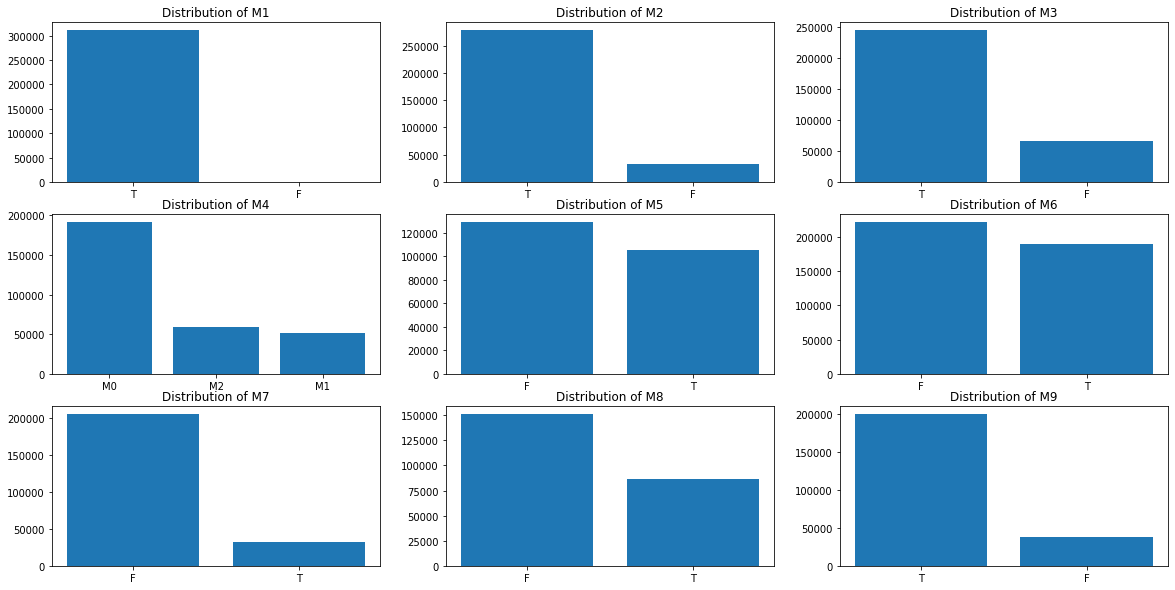

In [38]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (20,10))

value_counts_M1 = X_train['M1'].value_counts()
axes[0,0].bar(value_counts_M1.index, value_counts_M1.values)
axes[0,0].set_title("Distribution of M1")

value_counts_M2 = X_train['M2'].value_counts()
axes[0,1].bar(value_counts_M2.index, value_counts_M2.values)
axes[0,1].set_title("Distribution of M2")

value_counts_M3 = X_train['M3'].value_counts()
axes[0,2].bar(value_counts_M3.index, value_counts_M3.values)
axes[0,2].set_title("Distribution of M3")

value_counts_M4 = X_train['M4'].value_counts()
axes[1,0].bar(value_counts_M4.index, value_counts_M4.values)
axes[1,0].set_title("Distribution of M4")

value_counts_M5 = X_train['M5'].value_counts()
axes[1,1].bar(value_counts_M5.index, value_counts_M5.values)
axes[1,1].set_title("Distribution of M5")

value_counts_M6 = X_train['M6'].value_counts()
axes[1,2].bar(value_counts_M6.index, value_counts_M6.values)
axes[1,2].set_title("Distribution of M6")

value_counts_M7 = X_train['M7'].value_counts()
axes[2,0].bar(value_counts_M7.index, value_counts_M7.values)
axes[2,0].set_title("Distribution of M7")

value_counts_M8 = X_train['M8'].value_counts()
axes[2,1].bar(value_counts_M8.index, value_counts_M8.values)
axes[2,1].set_title("Distribution of M8")

value_counts_M9 = X_train['M9'].value_counts()
axes[2,2].bar(value_counts_M9.index, value_counts_M9.values)
axes[2,2].set_title("Distribution of M9")

plt.show()

Decision:
- We will fill the columns **M1, M2, M3, M4, M7, M8, M9** with their mode value as the distribution is heavily imbalanced. Hence, filling the missing values with the mode value will not changle the inherent distribution of these column
- For columns **M5, M6**, we will fill up the missing values by randomly allocating the 2 possible values. 

In [39]:
M_columns_mode = ['M1','M2','M3','M4','M7','M8','M9']
X_train[M_columns_mode] = X_train[M_columns_mode].fillna(mode_train[M_columns_mode])
X_test[M_columns_mode] = X_test[M_columns_mode].fillna(mode_test[M_columns_mode])

In [41]:
def allocate_missing_values(value1, value2):
    return np.random.choice([value1, value2], size=1)[0]

In [42]:
for column in ['M5','M6']:
    if X_train[column].isna().any():
        missing_mask = X_train[column].isna()
        values = X_train[column].dropna().unique()
        allocated_values = np.array([allocate_missing_values(*values) for _ in range(missing_mask.sum())])
        X_train.loc[missing_mask, column] = allocated_values

In [43]:
for column in ['M5','M6']:
    if X_test[column].isna().any():
        missing_mask = X_test[column].isna()
        values = X_test[column].dropna().unique()
        allocated_values = np.array([allocate_missing_values(*values) for _ in range(missing_mask.sum())])
        X_test.loc[missing_mask, column] = allocated_values

In [44]:
cols_with_missing_train = X_train.columns[X_train.isna().any()].tolist()
cols_with_missing_test = X_test.columns[X_test.isna().any()].tolist()
print("Number of missing columns in train dataset: ", len(cols_with_missing_train))
print("Number of missing columns in test dataset: ", len(cols_with_missing_test)) 

Number of missing columns in train dataset:  41
Number of missing columns in test dataset:  55


### 1.3.5 Investigation of Distribution (V columns)

In [46]:
V_columns = []
for col in remaining_cols:
    if 'V' in col:
        V_columns.append(col)
V_columns

['V1',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V14',
 'V17',
 'V20',
 'V23',
 'V26',
 'V27',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V56',
 'V59',
 'V62',
 'V65',
 'V67',
 'V68',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V89',
 'V91']

Decision:
- We will fill up the missing values of the V Columns with its **respective mode value.** 

In [52]:
X_train[V_columns] = X_train[V_columns].fillna(mode_train[V_columns])
X_test[V_columns] = X_test[V_columns].fillna(mode_test[V_columns])

In [53]:
cols_with_missing_train = X_train.columns[X_train.isna().any()].tolist()
cols_with_missing_test = X_test.columns[X_test.isna().any()].tolist()
print("Number of missing columns in train dataset: ", len(cols_with_missing_train))
print("Number of missing columns in test dataset: ", len(cols_with_missing_test)) 

Number of missing columns in train dataset:  4
Number of missing columns in test dataset:  18


### 1.3.6 Investigation of Columns (The Rest)

In [56]:
cols_with_missing_train = X_train.columns[X_train.isna().any()].tolist()
cols_with_missing_train

['addr1', 'addr2', 'dist1', 'P_emaildomain']

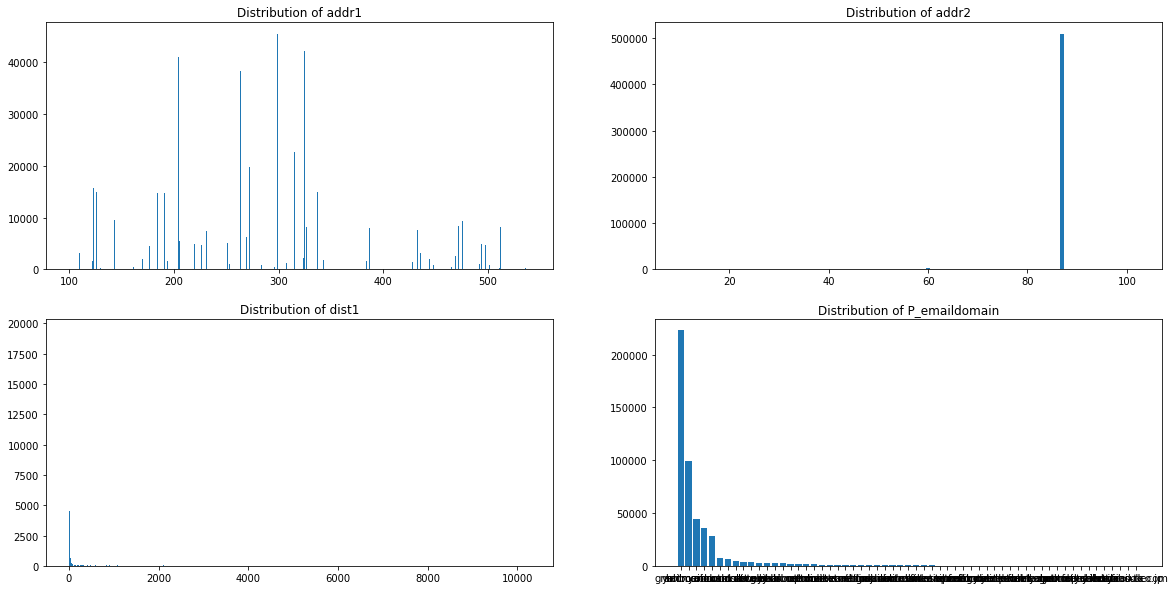

In [59]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20,10))

value_counts_addr1 = X_train['addr1'].value_counts()
axes[0,0].bar(value_counts_addr1.index, value_counts_addr1.values)
axes[0,0].set_title("Distribution of addr1")

value_counts_addr2 = X_train['addr2'].value_counts()
axes[0,1].bar(value_counts_addr2.index, value_counts_addr2.values)
axes[0,1].set_title("Distribution of addr2")

value_counts_dist1 = X_train['dist1'].value_counts()
axes[1,0].bar(value_counts_dist1.index, value_counts_dist1.values)
axes[1,0].set_title("Distribution of dist1")

value_counts_P_emaildomain = X_train['P_emaildomain'].value_counts()
axes[1,1].bar(value_counts_P_emaildomain.index, value_counts_P_emaildomain.values)
axes[1,1].set_title("Distribution of P_emaildomain")

plt.show()

Decision:
- We will fill the missing values of addr1 with its **mean value**.
- We will fill the missing values of addr2, dist1 and P_emaildomain with its **mode values**.

In [61]:
cols_with_missing_train = X_train.columns[X_train.isna().any()].tolist()
cols_with_missing_test = X_test.columns[X_test.isna().any()].tolist()
print("Number of missing columns in train dataset: ", len(cols_with_missing_train))
print("Number of missing columns in test dataset: ", len(cols_with_missing_test)) 

Number of missing columns in train dataset:  0
Number of missing columns in test dataset:  14


### 1.3.7 Missing C Columns in Test Dataset

In [62]:
cols_with_missing_test = X_test.columns[X_test.isna().any()].tolist()
cols_with_missing_test

['C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14']

In [64]:
for col in cols_with_missing_test:
    print(col, ":",(X_test[col].isna().mean() * 100).round(2))

C1 : 0.0
C2 : 0.0
C3 : 0.0
C4 : 0.0
C5 : 0.0
C6 : 0.0
C7 : 0.0
C8 : 0.0
C9 : 0.0
C10 : 0.0
C11 : 0.0
C12 : 0.0
C13 : 0.62
C14 : 0.0


We will remove the rows with missing values in these columns.

In [66]:
X_test.dropna(subset = cols_with_missing_test, inplace = True)
cols_with_missing_test = X_test.columns[X_test.isna().any()].tolist()
print("Number of missing columns in test dataset: ", len(cols_with_missing_test)) 

Number of missing columns in test dataset:  0


In [67]:
X_train.to_csv('train_dataset.csv')
X_test.to_csv('test_dataset.csv')